In [1]:
import numpy as np
import jax.numpy as jnp
import jax.lax as jlx
import jax
from matplotlib import pyplot as plt
from jax.scipy.integrate import trapezoid
from jax.scipy.optimize import minimize

In [2]:
y_real = lambda x: np.exp(-x[0]) * np.cosh(x[0]) # real function that solves the first-order Volterra Equation

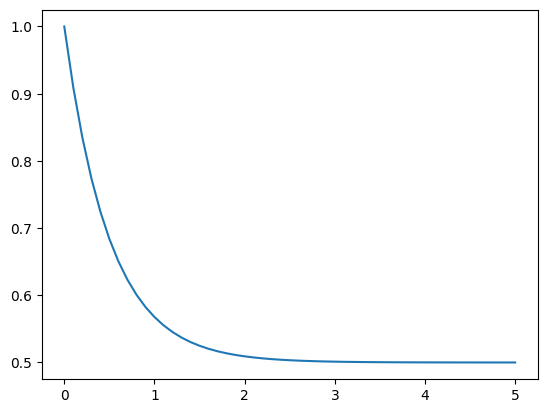

In [3]:
plt.plot([x for x in np.arange(0, 5.1, 0.1)], [y_real([x]) for x in np.arange(0, 5.1, 0.1)]); # plot the objective curve

In [4]:
# points for the constraining on initial conditions --> Dirichlet
passing_points_x = np.array([[0]])
passing_points_y = np.array([1])
passing_points_x, passing_points_y

(array([[0]]), array([1]))

In [5]:
# grid built on the domain, those are the points where the PINN will try to minimize the residual
grid = np.reshape(np.arange(0, 5.5, 0.5), (-1, 1))
grid.shape, grid # points in the convex interval I = [0, 5]

((11, 1),
 array([[0. ],
        [0.5],
        [1. ],
        [1.5],
        [2. ],
        [2.5],
        [3. ],
        [3.5],
        [4. ],
        [4.5],
        [5. ]]))

In [6]:
# initializing weights and biases for the whole neural networks
def initialize(layers_size):
  np.random.seed(0) # for reproducibility
  params = list()
  for i in range(len(layers_size) - 1):
    n, m = layers_size[i + 1], layers_size[i]
    params.append(np.random.normal(0, np.sqrt(2 / (n + m)), (n, m))) # matrix --> Normal(0, sqrt(2/n+m))
    params.append(np.zeros((n, ))) # vectors --> 0
  return params

layers = [1, 16, 8, 4, 1]
params = initialize(layers) # simple FFNN --> more layers with less nodes --> typical in PINN
len(params)

8

In [7]:
# functions for computing the forward pass of the network --> 2 variations
def ANN_layer(data, params):
    W, b = params
    return jlx.map(lambda x: jnp.dot(W, x) + b, data)

ANN_layer_fast = jax.jit(ANN_layer)

def ANN(x, params): # classic ANN architecture with FeedForward layers
  res = x
  for i in range(0, len(params) - 2, 2):
      res = jnp.tanh(ANN_layer_fast(res, params[i:i + 2])) # tanh(z) as the activation function --> typical in PINN
  res = ANN_layer_fast(res, params[-2:])
  return (res[:, 0] * x[:, 0]) + 1 # enforce Hard Constrains

ANN_fast = jax.jit(ANN)

def ANN_single_point(point, params): # same function, but for a single datapoint to forcast
    res = point
    for i in range(0, len(params) - 2, 2):
        res = jnp.tanh(jnp.dot(params[i], res) + params[i + 1])
    res = jnp.dot(params[-2], res) + params[-1]
    return (res[0] * point[0]) + 1 # enforce Hard Constrains

ANN_single_point_fast = jax.jit(ANN_single_point)

ANN_single_point_fast(grid[0], initialize(layers))

Array(1., dtype=float32)

In [8]:
# numerical approximation of the integral
def integrate(a, b, params): # Trapezoidal Rule
    x = jnp.linspace(a, b, 100)
    y = ANN_fast(x.reshape((-1, 1)), params) * jnp.exp(x - b)
    return trapezoid(y, x)

integrate(0, 5, params)

Array(3.1104128, dtype=float32)

In [9]:
# helper function, used to compute the derivative of the network with respect of the inputs
def ANN_separate(x, params):
    return ANN_fast(x.reshape((-1, 1)), params)

grad_x = jax.jit(jax.jacrev(ANN_separate, argnums=0))

# all the specific functions for the derivative needed
def y_der_x_(x, params):
    return jnp.diagonal(grad_x(x, params))
y_der_x_fast_ = jax.jit(y_der_x_)

# function for computing the numerical integral on all the points at the same time
def y_integral(b, params):
    return jlx.map(lambda x: integrate(0, x, params), b)

y_integral_fast = jax.jit(y_integral)

In [10]:
# implementation of the loss function, unifying of all the subcomponents of the loss
def loss_grid(params):
    y = ANN_fast(grid, params)
    y_der = y_der_x_fast_(grid[:, 0], params)
    y_int = y_integral_fast(grid[:, 0], params)
    return jnp.mean(jnp.square(y_der + y - y_int))

loss_grid_fast = jax.jit(loss_grid)

def loss(params):
    return loss_grid(params)

loss_fast = jax.jit(loss)
loss_grad = jax.jit(jax.grad(loss, argnums=0))
loss_fast(params)

Array(1.3326387, dtype=float32)

In [11]:
loss_grad(params);

In [12]:
# those 2 functions are needed to convert the parameters of the network from list of matrices to numpy array and viceversa
# those will be called a lot in the training cycle, in both ways, for working with the different shapes
# it's necessary because the forward pass uses the list of matrices form, while BFGS uses the numpy array version
def flat_list_into_numpy(params):
    return jnp.concatenate([p.reshape((-1, )) for p in params])

def unpack_params(params):
    params_list = list()
    idx, length = 0, 0
    for i in range(len(layers) - 1):
        length = layers[i] * layers[i + 1]
        params_list.append(params[idx: idx + length].reshape((layers[i + 1], layers[i])))
        idx += length

        length = layers[i + 1]
        params_list.append(params[idx: idx + length])
        idx += length
    return params_list

unpack_params_fast = jax.jit(unpack_params)
unpack_params_fast(flat_list_into_numpy(params));

In [13]:
def BFGS(w, dw, B_inv, lr_old):
    # search direction
    dir_v = -(B_inv @ dw)
    # line search
    lr = minimize(lambda x: loss_fast(unpack_params_fast(w + x[0] * dir_v)), jnp.array([0.1]), method="BFGS").x[0]
    if lr is None: # scipy may fail in finding the optimal search direction
        lr = lr_old
    lr_old = lr
    w_new = w + lr * dir_v # I use + sign because I inverted the sign of dir before
    dw_new = flat_list_into_numpy(loss_grad(unpack_params_fast(w_new)))
    # Sherman-Morrison update
    s = w_new - w
    y = dw_new - dw
    E = I - jnp.outer(y, s) / jnp.inner(y, s)
    B_inv = E.T @ B_inv @ E + jnp.outer(s, s) / jnp.inner(y, s)
    w = w_new
    dw = dw_new
    return w, dw, B_inv, lr_old

BFGS_fast = jax.jit(BFGS)

In [14]:
# BFGS optimization
w = flat_list_into_numpy(initialize(layers))

N = len(w)
max_epochs = 300
tol = 1e-6

dw = flat_list_into_numpy(loss_grad(unpack_params_fast(w)))
I = jnp.eye(N)
B_inv = I.copy()
history_train = list()

lr_old = 0.1

epoch = 0
while epoch < max_epochs and np.linalg.norm(dw) > tol:
    w, dw, B_inv, lr_old = BFGS_fast(w, dw, B_inv, lr_old)
    if epoch % 10 == 0:
        l = loss_fast(unpack_params_fast(w))
        history_train.append(l)
        print(f"epoch {epoch}")
        print(f"loss: {l}")
        print(f"gradient norm: {np.linalg.norm(dw)}")
    epoch += 1

print(f"\n\nLoss of the final iteration : {loss_fast(unpack_params_fast(w))}\n")

epoch 0
loss: 0.11642815917730331
gradient norm: 0.4869726598262787
epoch 10
loss: 9.824796143220738e-05
gradient norm: 0.003077896311879158
epoch 20
loss: 4.008178075309843e-05
gradient norm: 0.0022935611195862293
epoch 30
loss: 9.419131856702734e-06
gradient norm: 0.0009755691280588508
epoch 40
loss: 4.675564923672937e-06
gradient norm: 0.0004271373909432441
epoch 50
loss: 4.02241221308941e-06
gradient norm: 0.00013783341273665428
epoch 60
loss: 3.871909939334728e-06
gradient norm: 9.117864829022437e-05
epoch 70
loss: 3.7499473819480045e-06
gradient norm: 0.00017648372158873826
epoch 80
loss: 3.5220114114054013e-06
gradient norm: 0.0002327250549569726
epoch 90
loss: 3.1162619507085765e-06
gradient norm: 0.00019310812058392912
epoch 100
loss: 2.4762605335126864e-06
gradient norm: 0.0003753636556211859
epoch 110
loss: 1.4546880038324161e-06
gradient norm: 0.00062914052978158
epoch 120
loss: 4.5096098233443627e-07
gradient norm: 0.00040110459667630494
epoch 130
loss: 1.2541862304260576e

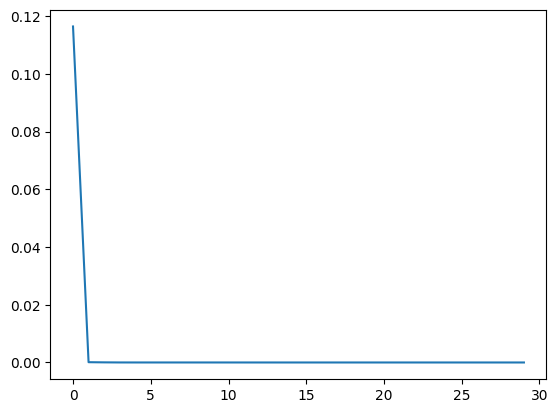

In [15]:
plt.plot(history_train);

In [16]:
params = unpack_params_fast(w)

# Plots for showing the results

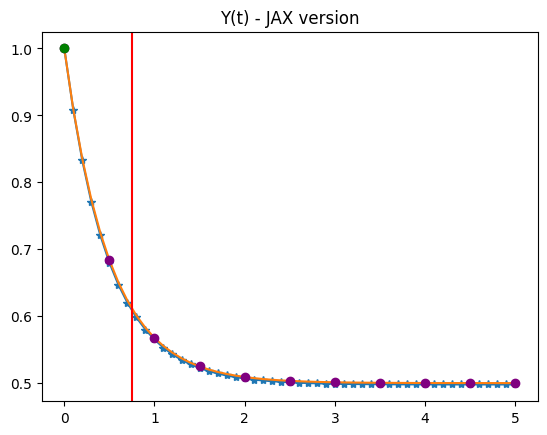

In [17]:
plt.title("Y(t) - JAX version")
plt.plot([x for x in np.arange(0, 5.1, 0.1)], [ANN_single_point_fast(np.array([x]), params) for x in np.arange(0, 5.1, 0.1)], marker="*", zorder=0)
plt.plot([x for x in np.arange(0, 5.1, 0.1)], [y_real([x]) for x in np.arange(0, 5.1, 0.1)], zorder=1)
plt.scatter([x for x in np.arange(0, 5.5, 0.5)], [y_real([x]) for x in np.arange(0, 5.5, 0.5)], marker="o", c="purple", zorder=2)
plt.axvline(x=0.75, c="r")
plt.scatter([x[0] for x in passing_points_x], [x for x in passing_points_y], c="g", zorder=3);

In [19]:
x = 0.75
real = np.round(np.float64(y_real([x])), 3)
pred = np.round(np.float64(ANN_single_point_fast(np.array([x]), params)), 3)
perc = np.round(np.float64(100 * (np.absolute(real - pred)) / real), 2)
print(f"In X = {x} the real function is Y = {real} and the PINN = {pred}. The error is around of {perc}%")

In X = 0.75 the real function is Y = 0.612 and the PINN = 0.609. The error is around of 0.49%
